In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.3', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.3', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
# import warnings; warnings.filterwarnings("ignore")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram

## we will solve a anti-ferromagnetic Ising Hamiltonian

$$ \mathcal{H}=\sum_{i}\sigma^z_i\sigma^z_{i+1} $$

This is a pure classical model with a laternating up-down ground state, which has two fold degeneracy. For system size $L=6$, the ground state energy is: $E_{min}=-6$. The two fold degenerate ground states are $|010101\rangle~\&~|101010\rangle$


## creating a lattice of 6 sites in one dimension with PBC in a graph

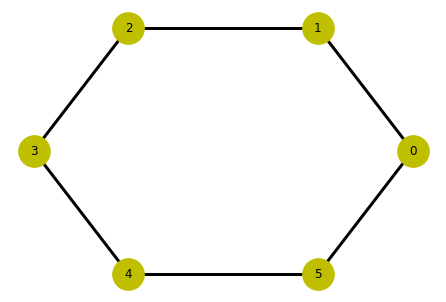

In [3]:
G = nx.Graph()
Lx=6
G.add_nodes_from([i for i in range(Lx)])
G.add_edges_from([[i,i+1] for i in range(Lx-1)])
G.add_edges_from([[Lx-1,0]])
options = {
    'node_color': 'y',
    'node_size': 1000,
    'width': 3,
}
nx.draw(G, with_labels=True,pos=nx.circular_layout(G),**options)

## Defining the rotation operator corresponding to the Hamiltonian

In [4]:
print(list(G.edges()))
print(G.number_of_nodes())

[(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)]
6


In [5]:
def ham_rot(G,gamma):
    L=G.number_of_nodes()
    qc=QuantumCircuit(L,L)
    for i,j in list(G.edges()):
        qc.cx(i,j)
        qc.rz(2*gamma,j)
        qc.cx(i,j)
    return qc

In [6]:
qc = ham_rot(G, np.pi/3)
print(G.edges())
qc.draw()

[(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)]


»
q_0: ──■────────────────■────■────────────────────────────■────────────»
     ┌─┴─┐┌──────────┐┌─┴─┐  │                            │            »
q_1: ┤ X ├┤ RZ(2π/3) ├┤ X ├──┼───────■────────────────────┼────■───────»
     └───┘└──────────┘└───┘  │     ┌─┴─┐    ┌──────────┐  │  ┌─┴─┐     »
q_2: ────────────────────────┼─────┤ X ├────┤ RZ(2π/3) ├──┼──┤ X ├──■──»
                             │     └───┘    └──────────┘  │  └───┘┌─┴─┐»
q_3: ────────────────────────┼────────────────────────────┼───────┤ X ├»
                             │                            │       └───┘»
q_4: ────────────────────────┼────────────────────────────┼────────────»
                           ┌─┴─┐┌──────────┐            ┌─┴─┐          »
q_5: ──────────────────────┤ X ├┤ RZ(2π/3) ├────────────┤ X ├──────────»
                           └───┘└──────────┘            └───┘          »
c: 6/══════════════════════════════════════════════════════════════════»
                                                                       »
«                                                                  
«q_0: ─────────────────────────────────────────────────────────────
«                                                                  
«q_1: ─────────────────────────────────────────────────────────────
«                                                                  
«q_2: ──────────────■──────────────────────────────────────────────
«     ┌──────────┐┌─┴─┐                                            
«q_3: ┤ RZ(2π/3) ├┤ X ├──■────────────────■────────────────────────
«     └──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐                      
«q_4: ─────────────────┤ X ├┤ RZ(2π/3) ├┤ X ├──■────────────────■──
«                      └───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
«q_5: ───────────────────────────────────────┤ X ├┤ RZ(2π/3) ├┤ X ├
«                                            └───┘└──────────┘└───┘
«c: 6/═════════════════════════════════════════════════════════════
«

In [7]:
def x_field_rot(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        qc.rx(2*beta, n)
    return qc

In [8]:
qc = x_field_rot(G, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ RX(2π/3) ├
     ├──────────┤
q_1: ┤ RX(2π/3) ├
     ├──────────┤
q_2: ┤ RX(2π/3) ├
     ├──────────┤
q_3: ┤ RX(2π/3) ├
     ├──────────┤
q_4: ┤ RX(2π/3) ├
     ├──────────┤
q_5: ┤ RX(2π/3) ├
     └──────────┘
c: 6/════════════

## defining the QAOA circuit

In [9]:
def qaoa_circuit(G,beta,gamma):
    assert(len(beta)==len(gamma))
    layer=len(beta)
    L=G.number_of_nodes()
    qc=QuantumCircuit(L,L)
    qc.h(range(L))
    for k in range(layer):
        qc=qc+ham_rot(G,gamma[k])
        qc=qc+x_field_rot(G,beta[k])
    qc.measure(range(L), range(L))
    return qc

### Let's verify that circuit looks right

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

This is the full circuit, with we will now choose, $p=1~;~\beta=\text{x-field angle};~\gamma=\text{Hamiltonian angle}$

In [10]:
qc = qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc.draw()

/Users/animeshnanda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  
/Users/animeshnanda/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


┌───┐                                               ┌──────────┐»
q_0: ┤ H ├──■─────────────■────■──────────────────────■──┤ RX(2π/3) ├»
     ├───┤┌─┴─┐┌───────┐┌─┴─┐  │                      │  └──────────┘»
q_1: ┤ H ├┤ X ├┤ RZ(π) ├┤ X ├──┼──────■───────────────┼───────■──────»
     ├───┤└───┘└───────┘└───┘  │    ┌─┴─┐  ┌───────┐  │     ┌─┴─┐    »
q_2: ┤ H ├─────────────────────┼────┤ X ├──┤ RZ(π) ├──┼─────┤ X ├────»
     ├───┤                     │    └───┘  └───────┘  │     └───┘    »
q_3: ┤ H ├─────────────────────┼──────────────────────┼──────────────»
     ├───┤                     │                      │              »
q_4: ┤ H ├─────────────────────┼──────────────────────┼──────────────»
     ├───┤                   ┌─┴─┐┌───────┐         ┌─┴─┐            »
q_5: ┤ H ├───────────────────┤ X ├┤ RZ(π) ├─────────┤ X ├────────────»
     └───┘                   └───┘└───────┘         └───┘            »
c: 6/════════════════════════════════════════════════════════════════»
                                                                     »
«                          ┌─┐                                                 »
«q_0: ─────────────────────┤M├─────────────────────────────────────────────────»
«     ┌──────────┐         └╥┘┌─┐                                              »
«q_1: ┤ RX(2π/3) ├──────────╫─┤M├──────────────────────────────────────────────»
«     └──────────┘          ║ └╥┘     ┌──────────┐         ┌─┐                 »
«q_2: ─────■────────────────╫──╫───■──┤ RX(2π/3) ├─────────┤M├─────────────────»
«        ┌─┴─┐    ┌───────┐ ║  ║ ┌─┴─┐└──────────┘         └╥┘     ┌──────────┐»
«q_3: ───┤ X ├────┤ RZ(π) ├─╫──╫─┤ X ├─────■────────────────╫───■──┤ RX(2π/3) ├»
«        └───┘    └───────┘ ║  ║ └───┘   ┌─┴─┐    ┌───────┐ ║ ┌─┴─┐└──────────┘»
«q_4: ──────────────────────╫──╫─────────┤ X ├────┤ RZ(π) ├─╫─┤ X ├─────■──────»
«                           ║  ║         └───┘    └───────┘ ║ └───┘   ┌─┴─┐    »
«q_5: ──────────────────────╫──╫────────────────────────────╫─────────┤ X ├────»
«                           ║  ║                            ║         └───┘    »
«c: 6/══════════════════════╩══╩════════════════════════════╩══════════════════»
«                           0  1                            2                  »
«                                        
«q_0: ───────────────────────────────────
«                                        
«q_1: ───────────────────────────────────
«                                        
«q_2: ───────────────────────────────────
«              ┌─┐                       
«q_3: ─────────┤M├───────────────────────
«              └╥┘     ┌──────────┐┌─┐   
«q_4: ──────────╫───■──┤ RX(2π/3) ├┤M├───
«     ┌───────┐ ║ ┌─┴─┐├──────────┤└╥┘┌─┐
«q_5: ┤ RZ(π) ├─╫─┤ X ├┤ RX(2π/3) ├─╫─┤M├
«     └───────┘ ║ └───┘└──────────┘ ║ └╥┘
«c: 6/══════════╩═══════════════════╩══╩═
«               3                   4  5

## inverting the count, since qiskit shows the qubit states from bellow

In [11]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [12]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend,shots=2048)          # this is just a test run for the above circuit
result = job.result()
print(result.get_counts())

{'101110': 22, '000010': 19, '000011': 29, '001101': 35, '100011': 34, '010010': 38, '111000': 33, '110000': 34, '011111': 30, '110011': 33, '101101': 43, '001100': 22, '101000': 36, '001010': 34, '011101': 40, '000000': 25, '110001': 42, '000101': 40, '010101': 39, '000001': 28, '100101': 21, '111011': 32, '110111': 33, '011001': 35, '001001': 27, '011011': 37, '001011': 26, '001000': 45, '111010': 20, '111100': 34, '100000': 32, '111110': 42, '011000': 34, '011110': 32, '100001': 26, '111001': 32, '010111': 36, '010001': 24, '010110': 39, '101010': 26, '110110': 34, '110101': 25, '001111': 33, '100100': 23, '001110': 26, '010011': 24, '111111': 29, '110100': 41, '101001': 28, '100111': 30, '101100': 26, '110010': 21, '101011': 30, '000100': 31, '000110': 39, '010000': 28, '100110': 28, '000111': 40, '010100': 42, '111101': 43, '011010': 45, '100010': 30, '101111': 31, '011100': 32}


In [13]:
def ising_energy(x,G):
    ener = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            ener -= 1
        elif x[i] == x[j]:
            # the edge is cut
            ener += 1
    return ener

ising_energy('010101', G),ising_energy('111110', G)

(-6, 2)

In [14]:
def compute_ising_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():             # meas and meas_count are the state and freq
#         print(type(meas),meas_count)
        obj_for_meas = ising_energy(meas, G)              # calling the state to compute the energy
        energy += obj_for_meas * meas_count
        total_counts += meas_count                      # energy is total energy of all the states
    return energy / total_counts                        # total_counts is total number of sampling

compute_ising_energy(invert_counts(result.get_counts()), G)

-0.00390625

In [15]:
invert_counts(result.get_counts());

# Using QASM simulator

In [16]:
# here p is the number of layer used for the optimize

def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        # theta is a 2*p length array, first 'p' entries are gamma and rest are beta
        beta = theta[:p]
        gamma = theta[p:]
        qc = qaoa_circuit(G,beta, gamma)
        counts = execute(qc, backend,shots=1024, seed_simulator=100).result().get_counts()
        # return the energy
        return compute_ising_energy(invert_counts(counts), G)
    return f

In [17]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)

init_point = np.array([0.81069872, 2.2067517 , 1.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 0.85060091, 3.137845  ])

# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sample

     fun: -5.8515625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 116
  status: 1
 success: True
       x: array([ 0.54157005,  1.77263501,  1.28841288,  2.30821843, -0.05181451,
        2.29358628,  6.03172624,  2.17980247,  0.83498733,  3.06720118])

In [18]:
# Once we have gotten the optimum beta and gamma we run the circuit again with the 

optimal_theta = res_sample['x']
qc = qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend,shots=2048).result().get_counts())
counts

{'011001': 1,
 '100010': 1,
 '010100': 1,
 '011011': 8,
 '010011': 2,
 '100101': 1,
 '101101': 5,
 '100100': 8,
 '110110': 12,
 '010101': 996,
 '101000': 1,
 '001101': 2,
 '110101': 1,
 '000111': 1,
 '110100': 1,
 '010010': 10,
 '001001': 11,
 '101010': 986}

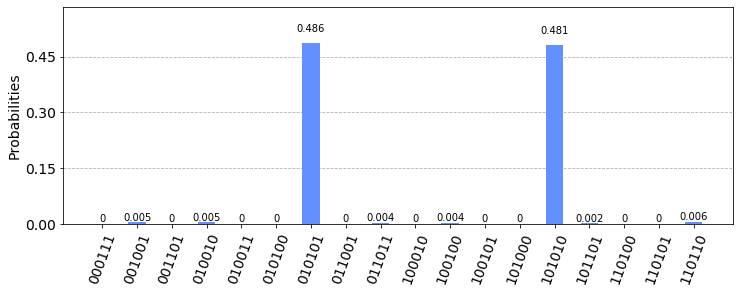

In [19]:
plot_histogram(counts,figsize=(12,4))

Best string: 010101 with cut: 6


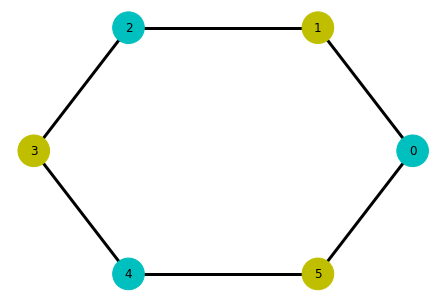

In [20]:
# get the best solution:
best_cut, best_solution = min([(ising_energy(x,G),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['c' if best_solution[node] == '0' else 'y' for node in G]
options = {
    'node_size': 1000,
    'width': 3,
}
nx.draw(G, with_labels=True,node_color = colors,pos=nx.circular_layout(G),**options)

## Using statevector simulator

In [21]:
def state_to_ampl_counts(vec, eps=1e-15):
    """Converts a statevector to a dictionary
    of bitstrings and corresponding amplitudes
    """
    qubit_dims = np.log2(vec.shape[0])
    if qubit_dims % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    qubit_dims = int(qubit_dims)
    counts = {}
    str_format = '0{}b'.format(qubit_dims)
    for kk in range(vec.shape[0]):
        val = vec[kk]
        if val.real**2+val.imag**2 > eps:
            counts[format(kk, str_format)] = val
    return counts

In [22]:
def compute_ising_energy_sv(sv, G):
    """Compute objective from statevector
    For large number of qubits, this is slow. 
    """
    counts = state_to_ampl_counts(sv)
    return sum(ising_energy(np.array([int(x) for x in k]), G) * (np.abs(v)**2) for k, v in counts.items())

In [23]:
def get_qaoa_circuit_sv(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for k in range(p):
        qc=qc+ham_rot(G,gamma[k])
        qc=qc+x_field_rot(G,beta[k])
    # no measurement in the end!
    return qc

In [24]:
def get_black_box_objective_sv(G,p):
    backend = Aer.get_backend('statevector_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit_sv(G,beta, gamma)
        sv = execute(qc, backend).result().get_statevector()  # the sv is np.array with complex entries
        # return the energy
        return compute_ising_energy_sv(sv, G)
    return f

In [25]:
# p is the number of QAOA alternating operators
obj = get_black_box_objective_sv(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])

p = len(init_point)//2

# We are going to limit the number of iterations to 2500
res_sv = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sv

     fun: -5.999999446187049
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 194
  status: 1
 success: True
       x: array([0.99174464, 2.07766338, 2.05875466, 2.31842956, 0.33916176,
       2.46176343, 5.9208742 , 2.41522885, 3.81955423, 6.09673571])

In [26]:
# Once we have gotten the optimum beta and gamma we run the circuit again with the 

backend = Aer.get_backend('qasm_simulator')

optimal_theta = res_sv['x']
qc = qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend,shots=2048).result().get_counts())
counts

{'101010': 1044, '010101': 1004}

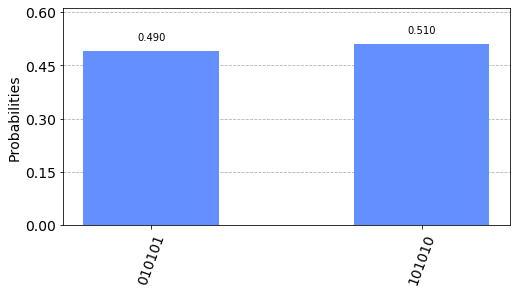

In [27]:
plot_histogram(counts,figsize=(8,4))

## Comparison between the angles

In [28]:
print(f"Angles found with samples: beta={res_sample['x'][:p]}, gamma={res_sample['x'][p:]}")
print(f"Angles found with full state: beta={res_sv['x'][:p]}, gamma={res_sv['x'][p:]}")

Angles found with samples: beta=[ 0.54157005  1.77263501  1.28841288  2.30821843 -0.05181451], gamma=[2.29358628 6.03172624 2.17980247 0.83498733 3.06720118]
Angles found with full state: beta=[0.99174464 2.07766338 2.05875466 2.31842956 0.33916176], gamma=[2.46176343 5.9208742  2.41522885 3.81955423 6.09673571]
